# Segmentation Exploration
Let's try a couple ways to align the gait cycle

In [1]:
#Imports
import pandas as pd
import os
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# EXPLORATION

In [2]:
#Convenience function for plotting a gait cycle
def plot_all_gait(gait_cycles):
    for i in range(len(gait_cycles)):
        print(f'Plotting cycle {i}.')
        plot_gait(gait_cycles[i])
        print('\n\n\n\n')
        
        if i > 5:
            print('That\'s enough for now.')
            return
        
        
def plot_gait(gait_cycle):
    plt.figure(figsize=(25, 10))
    plt.title('Acceleration')
    for i in range(4):
        plt.plot(gait_cycle[:, i], label=['x', 'y', 'z', 'mag'][i])
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(25, 10))
    plt.title('Gyroscope')
    for i in range(4):
        plt.plot(gait_cycle[:, i+ 4], label=['x', 'y', 'z', 'mag'][i])    
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(25, 10))
    plt.title('Attitude')
    for i in range(4):
        plt.plot(gait_cycle[:, i + 8], label=['x', 'y', 'z', 'w'][i])    
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(25, 10))
    plt.title('Gravity')
    for i in range(3):
        plt.plot(gait_cycle[:, i + 12], label=['x', 'y', 'z', 'mag'][i])    
    plt.legend()
    plt.show()

In [3]:
def quat_dist(quat1, quat2):
    '''
    Returns a distance measure between two quatrions. 0 when quats are same, 1 when quats are 180 deg apart
    '''
    
    return 1 - (np.dot(quat1, quat2)**2)

def is_valid_window(window, acc_mag_std, gyr_mag_std, att_delta_mean):
    
    acc_mag_max = np.max(window[:, 3])
    if acc_mag_max < 2*acc_mag_std:
        return False
    
    acc_mag = window[:, 3]
    mean_delta = np.mean(np.abs(np.diff(acc_mag)))
    if mean_delta < 0.1*acc_mag_std:
        return False
    
    if mean_delta > 0.5*acc_mag_std:
        return False
    
    atts = window[:, 8:12]
    att_delta = [quat_dist(atts[i], atts[i + 1]) for i in range(len(atts) - 1)]
    
    #if np.mean(att_delta) < 0.5*att_delta_mean:
    #    return False
    
    if np.mean(att_delta) > 2*att_delta_mean:
        return False
    
    
    return True

def make_windows(gait_cycle, window_size = 100, window_overlap = 50):

    data = []
    
    curr_pos = 0
    while curr_pos < (gait_cycle.shape[0] - window_size):
        window = gait_cycle[curr_pos : curr_pos + window_size]
        curr_pos += window_size - window_overlap

        if is_valid_window(window):
            data.append(window)


    data = np.dstack(data).transpose((2, 0, 1))
    return data

def clean_6mwt(gait_cycle, window_size = 50, window_overlap = 0):
    
    
    new_cycle = np.copy(gait_cycle)
    
    curr_pos = 0
    
    exclude = False
    
    acc_std_mag = np.std(gait_cycle[:, 3])
    gyr_std_mag = np.std(gait_cycle[:, 7])
    atts = gait_cycle[:, 8:12]
    att_mean = np.mean([quat_dist(atts[i], atts[i + 1]) for i in range(len(atts) - 1)])
    
    while curr_pos < (new_cycle.shape[0] - window_size):
        window = new_cycle[curr_pos : curr_pos + window_size]
        
        
        if not is_valid_window(window, acc_std_mag, gyr_std_mag, att_mean):
            new_cycle[curr_pos : curr_pos + window_size] = np.nan
        
        curr_pos += window_size - window_overlap

    return new_cycle

In [4]:
#Functions acting on the gait as a whole
def screen_cycle(cycle, min_len = 600, min_valid_prop = 0.5):
    '''
    Deletes any bits of the cycle that have a continuous length shorter than min_len.
    Returns None if cycle is thrown out
    '''
    #Throw out cycles with too many errors
    prop_nan = np.count_nonzero(np.isnan(cycle)) / cycle.size
    if prop_nan > (1 - min_valid_prop):
        return None
    
    curr_len = 0
    for i in range(cycle.shape[0]):
        if not np.isnan(cycle[i, 0]):
            curr_len += 1
        else:
            #Delete if too short
            if curr_len < min_len:
                cycle[max(i-curr_len, 0) : i] = np.nan
            
            #Reset length count
            curr_len = 0
            
    #Handle the last bit of each cycle
    if curr_len < min_len:
        cycle[-curr_len :] = np.nan
            
    return cycle

In [5]:
#function to do all the above
def filter_6mwt_main(test):
    new_test = clean_6mwt(test)

    new_test = screen_cycle(new_test)
    if type(new_test) == np.ndarray and len(new_test) > 0:
        new_test = new_test[~np.all(np.isnan(new_test), axis=1), :]
            
        return new_test
    else:
        return None

# Exploration

In [6]:
def get_gender_hcs():
    '''
    Returns a list of healthcodes for extraction. Takes in a path to a tsv table.
    '''
    table_folder = "/oak/stanford/groups/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.json.patientBiologicalSex', 
             'NonIdentifiableDemographics.patientBiologicalSex']]

    print(f"Starting with {df.shape[0]} records")

    #Merge weights and heights
    df['Sex'] = df['NonIdentifiableDemographics.patientBiologicalSex'].fillna(df['NonIdentifiableDemographics.json.patientBiologicalSex'])
    df = df[['healthCode', 'Sex']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")

    df = df[(df.Sex == 'Male') | (df.Sex == 'Female')]
    print(f"Dropping invalid sex values gives {df.shape[0]} users")
    
    return list(df.index), df


In [7]:
#Load some nice windows
window_size = 500 #1 second
window_overlap = 0 #0.5 seconds
num_windows_wanted = 5
windows = []

#Define which healthcodes you want
target = "Sex"
valid_hcs, df = get_gender_hcs()

curr_window = 0
data_path = r'/oak/stanford/groups/euan/projects/mhc/code/daniel_code/data/raw'
for filename in os.listdir(data_path):
    hc = filename[:-4]
    if hc in valid_hcs:
        data = []
        labels = []
        ids = []

        path = os.path.join(data_path, filename)
        six_mwt = np.load(path)
        
        #Filter the test
        six_mwt = filter_6mwt_main(six_mwt)
        if type(six_mwt) != np.ndarray:
            continue
        
        curr_pos = 0
        while curr_pos < (six_mwt.shape[0] - window_size):
            window = six_mwt[curr_pos : curr_pos + window_size]
            curr_pos += window_size - window_overlap
        
            try:
                data.append(window)
                labels.append(df.loc[hc, target])
                ids.append(hc)
            except TypeError as e:
                print(e)
        print(hc)
        
        if len(labels) == 0:
            print('Had no extracted windows!')
            continue
        

        
        data = np.dstack(data).transpose((2, 0, 1))
        labels = np.array(labels)
        ids = np.array(ids)
        print(data.shape, labels.shape, ids.shape)
        windows.append(data)
        
        curr_window += 1
        if curr_window >= num_windows_wanted:
            break
        

/home/users/danjwu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Starting with 48655 records
Dropping NaNs gives 40991 users
Dropping duplicate healthcodes gives 23367 users
Dropping invalid sex values gives 23367 users
b2fc40e3-5d2e-44ca-a3da-01e40ba6a6d8
(11, 500, 15) (11,) (11,)
64e120a3-732a-4e2d-9ec2-aac7ffccee89
(6, 500, 15) (6,) (6,)
bb5bf21d-d1ea-48c7-9305-5f9e84248e33
(46, 500, 15) (46,) (46,)
5372067c-4544-409a-a864-49e7ea899632
(15, 500, 15) (15,) (15,)
cfd17899-b821-41e3-a4db-3f009bf908db
(65, 500, 15) (65,) (65,)


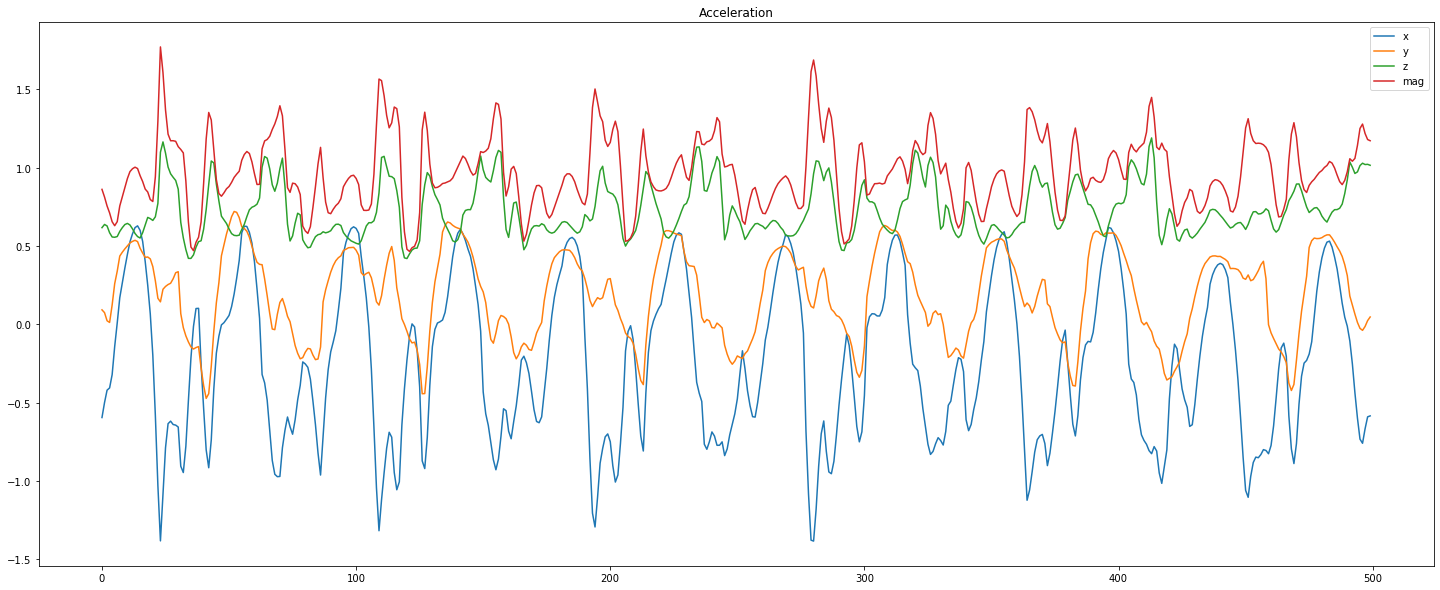

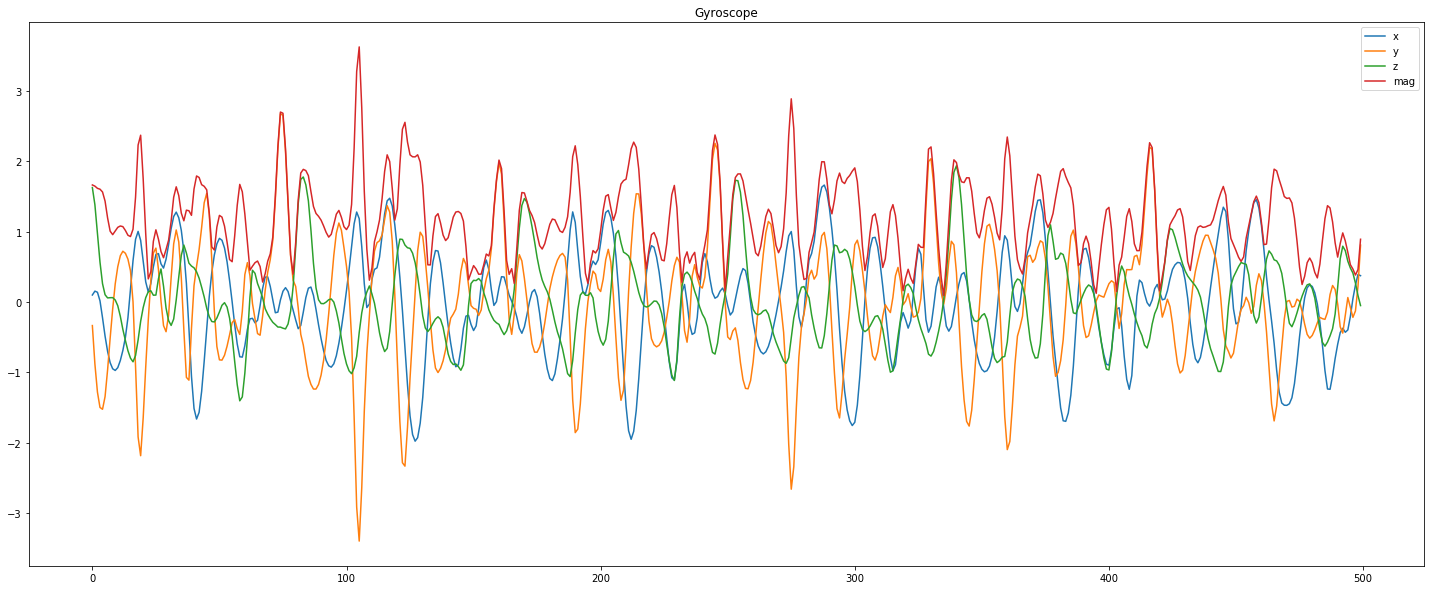

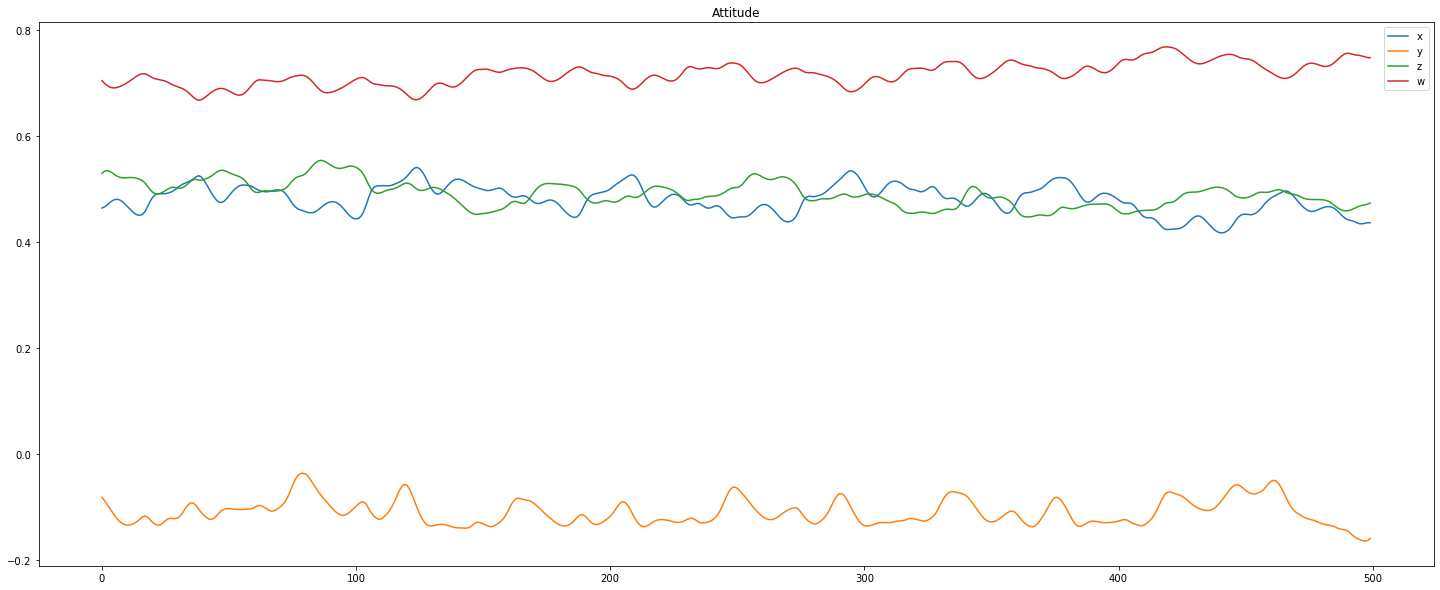

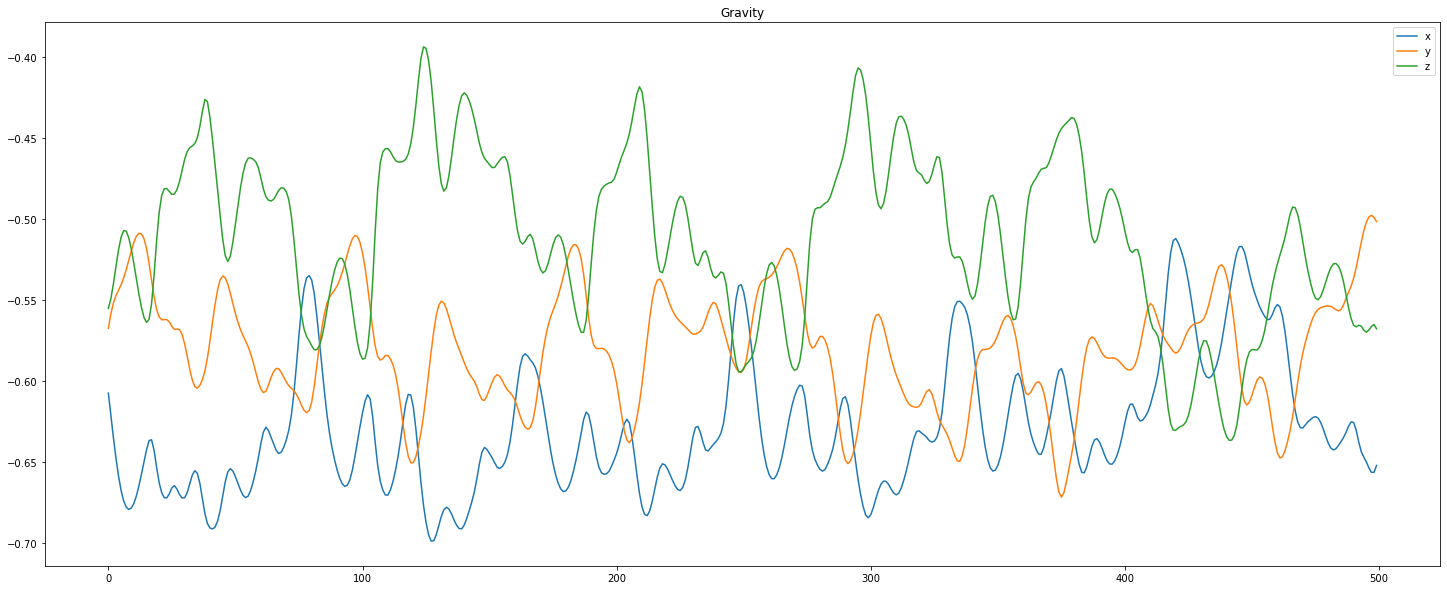

In [8]:
plot_gait(windows[2][10])

In [9]:
import scipy
from scipy import optimize
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:20])+1])   # excluding the zero frequency "peak", which is related to offset and capping at 20hz
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=10000)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

Amplitude=-0.2812551474472525, Angular freq.=0.15081416461541045, freq.=0.024002819786817387 phase=-0.33491353756762215, offset=1.2279037942824804, Max. Cov.=0.015150135284791564


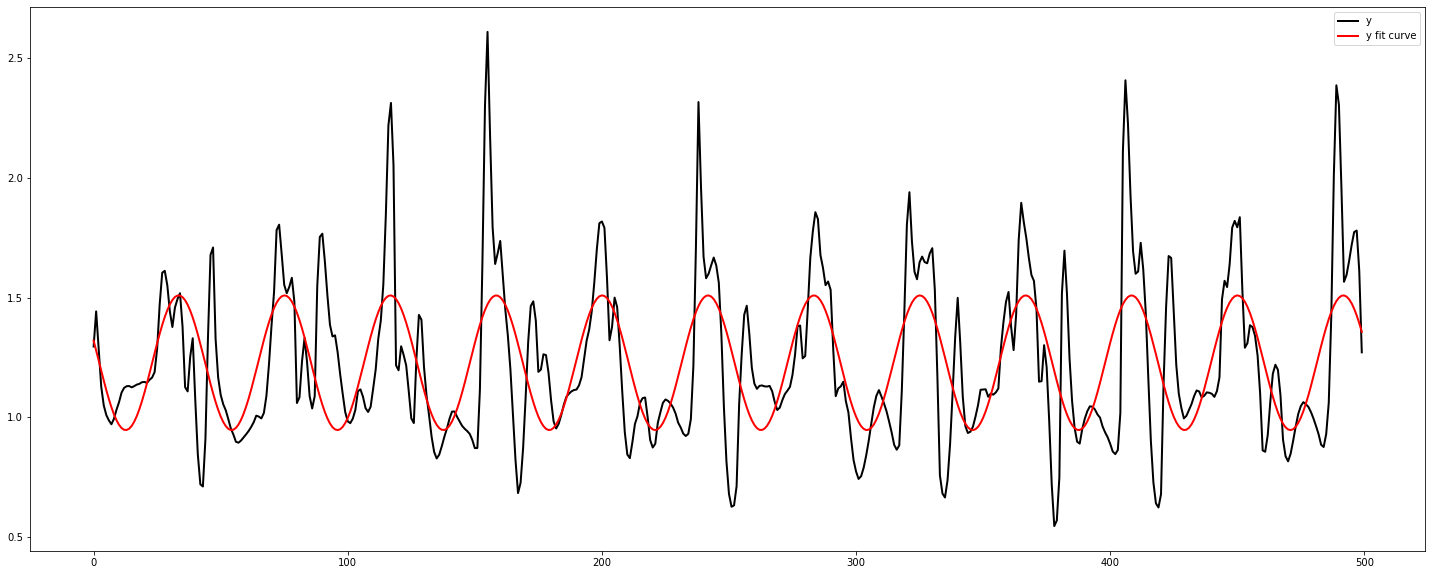

In [10]:
tt = np.arange(500)
yy = windows[2][15][:, 3]
res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, freq.=%(freq)s phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
plt.figure(figsize=(25, 10))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [11]:
zero_points = np.arange(res["phase"] + 0.25/res["freq"], max(tt), 2/res["freq"]).astype(int)
zero_points

array([ 10,  93, 176, 260, 343, 426])

In [12]:
(4*np.pi - res['phase'])/res['omega']

85.54424701967629

In [13]:
zero_points = np.arange((np.pi - res['phase'])/res['omega'], max(tt), 4*np.pi/res['omega']).astype(int)
zero_points

array([ 23, 106, 189, 273, 356, 439])

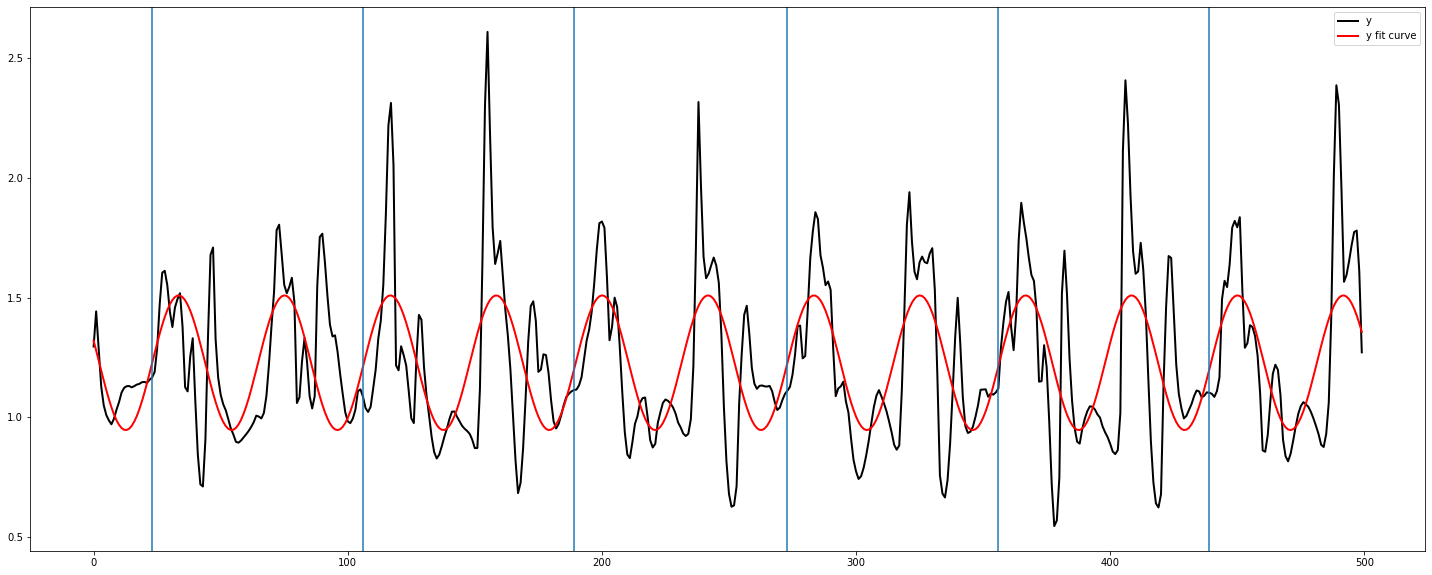

In [14]:
plt.figure(figsize=(25, 10))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
for zero_point in zero_points:
    plt.axvline(x=zero_point)
plt.show()

In [15]:
def segment_window(window, plot = False):
    res = fit_sin(np.arange(window.shape[0]), window[:, 3])
    zero_points = np.arange((np.pi - res['phase'])/res['omega'], max(tt), 4*np.pi/res['omega']).astype(int)
    
    if len(zero_points) <= 1:
        return np.array([])

    if plot:
        print(res)

        plt.figure(figsize=(25, 10))
        plt.plot(np.arange(window.shape[0]), window[:, 3], "-k", label="y", linewidth=2)
        plt.plot(np.arange(window.shape[0]), res["fitfunc"](np.arange(window.shape[0])), "r-", label="y fit curve", linewidth=2)
        plt.legend(loc="best")
        for zero_point in zero_points:
            plt.axvline(x=zero_point)
        plt.show()
    
    
    output = np.zeros((len(zero_points) - 1, 100, 15))
    for i in range(len(zero_points) - 1):
        segment = window[zero_points[i] : zero_points[i+1]]
        if segment.shape[0] <= 50:
            continue
        
        for dim_num in range(15):
            output[i, :, dim_num] = np.interp(np.linspace(0, segment.shape[0], 100), np.arange(segment.shape[0]), segment[:, dim_num])
    
    return output
    
test = segment_window(windows[1][4])

# Make an aligned dataset

In [16]:
# We have 8270 total users who did 6mwt
data_path = r'/oak/stanford/groups/euan/projects/mhc/code/daniel_code/data/raw'

In [20]:
def get_gender_hcs():
    '''
    Returns a list of healthcodes for extraction. Takes in a path to a tsv table.
    '''
    table_folder = "/oak/stanford/groups/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.json.patientBiologicalSex', 
             'NonIdentifiableDemographics.patientBiologicalSex']]

    print(f"Starting with {df.shape[0]} records")

    #Merge weights and heights
    df['Sex'] = df['NonIdentifiableDemographics.patientBiologicalSex'].fillna(df['NonIdentifiableDemographics.json.patientBiologicalSex'])
    df = df[['healthCode', 'Sex']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")

    df = df[(df.Sex == 'Male') | (df.Sex == 'Female')]
    print(f"Dropping invalid sex values gives {df.shape[0]} users")
    
    return list(df.index), df

def get_age_hcs():
    '''
    Returns a list of healthcodes for extraction. Takes in a path to a tsv table.
    '''
    
    table_folder = "/oak/stanford/groups/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.patientCurrentAge',
             'NonIdentifiableDemographics.json.patientCurrentAge']]

    print(f"Starting with {df.shape[0]} records")

    #Merge weights and heights
    df['Age'] = df['NonIdentifiableDemographics.patientCurrentAge'].fillna(df['NonIdentifiableDemographics.json.patientCurrentAge'])
    df = df[['healthCode', 'Age']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")

    
    #Drop invalid age values (non-integer)
    #df = df[df.Age.apply(lambda x: str(x).isdigit())]

    df = df[df['Age'] < 100]
    df = df[df['Age'] > 18]
    print(f"Dropping invalid ages (18 > w or w > 100) gives {df.shape[0]} users")
    
    return list(df.index), df

def get_BMI_hcs():
    table_folder = "/oak/stanford/groups/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.json.patientWeightPounds',
             'NonIdentifiableDemographics.json.patientHeightInches', 
             'NonIdentifiableDemographics.patientWeightPounds',
             'NonIdentifiableDemographics.patientHeightInches',]]

    print(f"Starting with {df.shape[0]} records")

    #Merge weights and heights
    df['Weight'] = df['NonIdentifiableDemographics.patientWeightPounds'].fillna(df['NonIdentifiableDemographics.json.patientWeightPounds'])
    df['Height'] = df['NonIdentifiableDemographics.patientHeightInches'].fillna(df['NonIdentifiableDemographics.json.patientHeightInches'])
    df = df[['healthCode', 'Weight', 'Height']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")


    df = df[df['Weight'] < 1000]
    df = df[df['Weight'] > 10]
    print(f"Dropping invalid weights (10 > w or w > 1000 pounds) gives {df.shape[0]} users")

    df = df[df['Height'] < 96]
    df = df[df['Height'] > 36]
    print(f"Dropping invalid weights (36 inches (3ft) > h or h > 96 inches (8ft)) gives {df.shape[0]} users")
    
    df['BMI'] = 703*(df['Weight'] / df['Height']) / df['Height']

    
    return list(df.index), df

def get_health_hcs(target):
    table_folder = "/oak/stanford/groups/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, r'cardiovascular-par-q quiz-v1.tsv')

    df = pd.read_csv(table_path, sep='\t')
    
    if target not in ['chestPain', 
             'chestPainInLastMonth', 
             'dizziness',
             'heartCondition', 
             'jointProblem', 
             'physicallyCapable',
             'prescriptionDrugs']:
        print("Invalid target")
        raise ValueError
    
    df = df[['healthCode', 
             target]]

    print(df.isna().sum())

    print(f"Starting with {df.shape[0]} records")

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")

    
    for col in df:    
        print(df[col].value_counts())
    
    return list(df.index), df

In [25]:
target = 'heartCondition'
suffix = 'aligned'

temp_dir = f'temp_dirs/{target}_temp_{suffix}'
temp_dir2 = f'temp_dirs/{target}_chunked_{suffix}'

In [ ]:
# Parse feature dataset with windows, with intermittent saving
window_size = 500 #1 second
window_overlap = 0 #0.5 seconds

if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
    os.mknod(temp_dir + '/done.txt')

#Define which healthcodes you want
if target == "BMI":
    valid_hcs, df = get_BMI_hcs()
elif target == "Age":
    valid_hcs, df = get_age_hcs()
elif target == "Sex":
    valid_hcs, df = get_gender_hcs()
else:
    valid_hcs, df = get_health_hcs(target)


with open(os.path.join(temp_dir, 'done.txt'), 'r') as progress_file:
    done_hcs = [x.strip() for x in progress_file.readlines()]

print(f'Finished {len(done_hcs)} last time, continuing.')

for filename in os.listdir(data_path):
    hc = filename[:-4]
    if hc in valid_hcs and hc not in done_hcs:
        data = []
        labels = []
        ids = []

        path = os.path.join(data_path, filename)
        six_mwt = np.load(path)
        
        #Filter the test
        six_mwt = filter_6mwt_main(six_mwt)
        if type(six_mwt) != np.ndarray:
            continue
            
        
        
        curr_pos = 0
        while curr_pos < (six_mwt.shape[0] - window_size):
            window = six_mwt[curr_pos : curr_pos + window_size]
            curr_pos += window_size - window_overlap
        
            try:
                
                #Align gait cycles
                datum = segment_window(window)
                
                for i in range(datum.shape[0]):
                    data.append(datum[i])
                    labels.append(df.loc[hc, target])
                    ids.append(hc)
            except TypeError as e:
                print(e)
        print(hc)
        
        if len(labels) == 0:
            print('Had no extracted windows!')
            continue
        
        data = np.dstack(data).transpose((2, 0, 1))
        labels = np.array(labels)
        ids = np.array(ids)
        print(data.shape, labels.shape, ids.shape)
        np.save(os.path.join(temp_dir, f'{hc}_data.npy'), data)
        np.save(os.path.join(temp_dir, f'{hc}_labels.npy'), labels)
        np.save(os.path.join(temp_dir, f'{hc}_ids.npy'), ids)
        
        with open(os.path.join(temp_dir, "done.txt"), "a") as progress_file:
            progress_file.write(hc + '\n')
        

healthCode         0
heartCondition    80
dtype: int64
Starting with 54787 records
Dropping NaNs gives 54707 users
Dropping duplicate healthcodes gives 44677 users
False    41579
True      3098
Name: heartCondition, dtype: int64
Finished 0 last time, continuing.
b2fc40e3-5d2e-44ca-a3da-01e40ba6a6d8
(40, 100, 15) (40,) (40,)
64e120a3-732a-4e2d-9ec2-aac7ffccee89
(27, 100, 15) (27,) (27,)
bb5bf21d-d1ea-48c7-9305-5f9e84248e33
(226, 100, 15) (226,) (226,)
5372067c-4544-409a-a864-49e7ea899632
(60, 100, 15) (60,) (60,)
cfd17899-b821-41e3-a4db-3f009bf908db
(346, 100, 15) (346,) (346,)
631f5fda-1f62-4981-8cc2-51362e88ef53
(99, 100, 15) (99,) (99,)
a94655a7-a64d-46fb-b3c2-f2b075d4add9
(96, 100, 15) (96,) (96,)
ada80fff-8286-430b-a65d-64496df543e0
(298, 100, 15) (298,) (298,)
f58dfe30-c34e-48b0-b5aa-56d6d42d506b
(243, 100, 15) (243,) (243,)
84b7f308-6363-47c4-a4f2-aa521c355c71
(368, 100, 15) (368,) (368,)
1ccd30e3-4131-4d3e-a97d-a9de4282eccf
(177, 100, 15) (177,) (177,)
564e06ff-4152-4664-a4d6-de

In [ ]:
#Concatenate all the npys and save the dataset, intermittently
temp_dir2 = f'temp_dirs/{target}_chunked_{suffix}'

if not os.path.exists(temp_dir2):
    os.mkdir(temp_dir2)

with open(os.path.join(temp_dir, 'done.txt'), 'r') as progress_file:
    all_hcs = [x.strip() for x in progress_file.readlines()]
 
chunk_size = 500
num_chunks = len(all_hcs) // chunk_size + 1
print(f'There are {len(all_hcs)} healthcodes, which will be saved in {num_chunks} chunks.')

start_chunk = 0
for curr_chunk in range(start_chunk, num_chunks):
    
    feats = [] 
    labels = []
    ids = [] 
    
    for counter in range(min(chunk_size, len(all_hcs) - chunk_size*curr_chunk)):
        hc = all_hcs[chunk_size*curr_chunk + counter]
    
        feat = np.load(os.path.join(temp_dir, f'{hc}_data.npy'))
        label = np.load(os.path.join(temp_dir, f'{hc}_labels.npy'))
        temp_id = np.load(os.path.join(temp_dir, f'{hc}_ids.npy'))

        feats.append(feat)
        labels.append(label)
        ids.append(temp_id)
            
    feats = np.concatenate(feats, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    ids = np.concatenate(ids, axis = 0)

    np.save(os.path.join(temp_dir2, f'{curr_chunk}_data.npy'), feats)
    np.save(os.path.join(temp_dir2, f'{curr_chunk}_labels.npy'), labels)
    np.save(os.path.join(temp_dir2, f'{curr_chunk}_ids.npy'), ids)
    
    print(f'Saving chunk {curr_chunk}')

print("All done!")

In [ ]:
# Finally actually save all the npy together

#num_chunks = 7
feats = []
labels = []
ids = []
for curr_chunk in range(num_chunks):
    feats.append(np.load(os.path.join(temp_dir2, f'{curr_chunk}_data.npy')))
    labels.append(np.load(os.path.join(temp_dir2, f'{curr_chunk}_labels.npy')))
    ids.append(np.load(os.path.join(temp_dir2, f'{curr_chunk}_ids.npy')))

feats = np.concatenate(feats, axis = 0)
labels = np.concatenate(labels, axis = 0)
ids = np.concatenate(ids, axis = 0)
    
print(feats.shape, labels.shape, ids.shape)
    
np.save(f'processed_datasets/{target}_X_15_{suffix}.npy', feats)
np.save(f'processed_datasets/{target}_y_15_{suffix}.npy', labels)
np.save(f'processed_datasets/{target}_ids_15_{suffix}.npy', ids)